# Notebook for preprocessing input data generating adjacency matrix & outcome collector

In [1]:
%matplotlib inline
import sys
sys.path.append('project_modules')

# Import libraries for geomatics
import geopandas as gp
from geopy.distance import vincenty, great_circle
from iso3166 import countries
from shapely.geometry import MultiPoint, Polygon, Point, shape
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from haversine import haversine

# # Import libraries for visualization
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('white')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = 20, 8

# Import libraries for data handling
import pandas as pd
import numpy as np
import random
import networkx as nx

In [3]:
# Convenience functions
def save_fig(fig, directory, name):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.
    
    Parameters
    ----------
    fig : a Figure instance
    dir : str
          the directory where figures are to be saved
    name : str
    
    '''
    plt.savefig('{}/{}_low_res.png'.format(directory, name), dpi=75, 
                                             bbox_inches='tight', transparent=True)
    plt.savefig('{}/{}_hig_res.png'.format(directory, name), dpi=300, 
                                              bbox_inches='tight', transparent=True)   

#### Load geodata with zonal stats and select columns of interest 

In [4]:
gdf_map_elements = gp.read_file('preprocessing_results/geojson/gdf_map_elements.geojson')
import matplotlib_polygon_lst
dict_mapindex_mpl_polygon = matplotlib_polygon_lst.add(gdf_map_elements)

## Determine adjacency regions


#### Prepare dicts to refer from index to country and vise versa

In [5]:
dict_index_country = gdf_map_elements['country'].to_dict()
dict_country_index = {v: k for k, v in dict_index_country.items()}

#### Drop minor islands where no values are in raster data and exclude regions with no suitability for Zika


In [6]:
gdf_model_elements = gdf_map_elements[gdf_map_elements.suitability_max 
                                      > gdf_map_elements.suitability_max.quantile(.10)]                                      
                                      
gdf_model_elements = gdf_model_elements[gdf_model_elements['population'] > 10000]

print 'Nr of model elements:', len(gdf_model_elements), 'Nr of map elements', len(gdf_map_elements)

Nr of model elements: 640 Nr of map elements 763


In [7]:
gdf_model_elements.tail(2)

,Crude_Birth_rate,Messinamea,Poverty_WB,continent,country,country_code,geometry,perc_pover,population,pregnancies,suitability_max,mpl_polygon
761,34.468975,0.15045,None,Africa,S. Sudan,SDS,"POLYGON ((31.62058190313229 5.881682644538429,...",90.977509,5.211739e+06,134732.482152,0.289519,"[Poly((31.6206, 5.88168) ...)]"
762,19.345307,0.00875,None,Asia,West Bank,PSX,"POLYGON ((35.21035935420042 32.54186756286899,...",17.215887,3.352553e+06,48642.118001,0.192328,"[Poly((35.2104, 32.5419) ...)]"


#### Plot Model elements in comparison to map elements

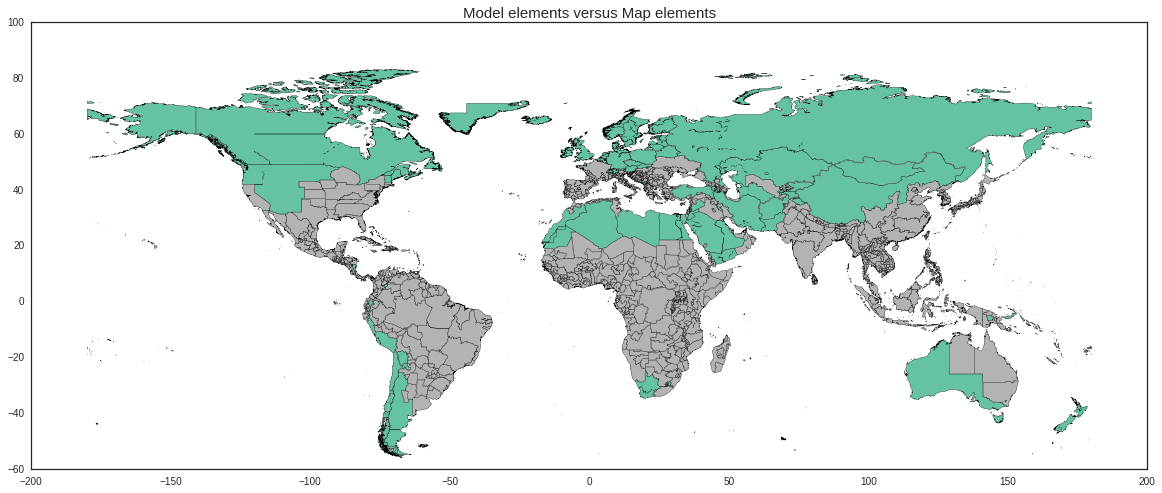

In [9]:
from matplotlib import cm
category = lambda x: True if (x in gdf_model_elements.index.tolist()) else False
gdf_map_elements['index1'] = gdf_map_elements.index
gdf_map_elements['model_element'] = gdf_map_elements.index1.apply(category)
gdf_map_elements.drop('index1', axis=1, inplace=True)

categories = np.unique(gdf_map_elements ['model_element'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_map_elements ["color"] = gdf_map_elements ['model_element'].apply(lambda x: colordict[x])

fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    color = gdf_map_elements .loc[c_l, 'color']
    p = PatchCollection(patches,color=cm.Set2(color),lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()
gdf_map_elements .drop('color', axis=1, inplace=True)
ax.set_title('Model elements versus Map elements', fontsize=15)

gdf_map_elements.drop('model_element', axis=1, inplace=True)
save_fig(fig, './figs/', 'Modelelements_worldmap_cutoff_20%')

plt.show()

#### Determine largest polygon geometry (of multipolygon) and its centroid
The motivation to take the largest polygon instead of the whole multipolygon is that some countries as Netherlands or France have several overseas regions across the world. Consequently, when aggregating regions to country level France becomes a directly neighbor of Colombia

In [10]:
gdf_model_elements["largest_polygon_geometry"] = np.nan
gdf_model_elements["centroid_largest_landmas"] = np.nan
gdf_model_elements['largest_polygon_geometry'] = gdf_model_elements['largest_polygon_geometry'].astype(object)
gdf_model_elements['centroid_largest_landmas'] = gdf_model_elements['centroid_largest_landmas'].astype(object)

for self_index, self_row_df in gdf_model_elements.iterrows():
    
    m_polygon = self_row_df['geometry']

    if m_polygon.geom_type == 'MultiPolygon':
        poly=[]
        for pol in m_polygon:
            poly.append(pol)
        max_area_region = max(poly, key=lambda i: i.area) #Get max value based on lambda function - area!
    else:
        max_area_region = m_polygon
    
    x, y = m_polygon.centroid.coords.xy
    centroid = [x[0], y[0]]
    
    gdf_model_elements.set_value(self_index, 'largest_polygon_geometry', max_area_region)   
    gdf_model_elements.set_value(self_index, 'centroid_largest_landmas', centroid)   

#### Identify adjacency regions based on whether polygons touch or intersect and save in adjacency_matrix

In [11]:
lst_adjacency_regions = []
for self_index, self_row_df in gdf_model_elements.iterrows():
    
    self_outline = self_row_df['largest_polygon_geometry']
    for other_index, other_df_row in gdf_model_elements.iterrows():

        if self_index == other_index: continue
        other_outline = other_df_row['largest_polygon_geometry']
        
        if self_outline.touches(other_outline) or self_outline.intersects(other_outline):
            lst_adjacency_regions.append((self_index, other_index))

#### Add not already included adjacency regions based on neighboorhood when centroids of regions  form a Delaunay Triangulation 

In computational geometry, a Delaunay triangulation for a set of points in a plane is a triangulation such that no point is inside the circumcircle of any triangle. The resulting network structure is similiar to a voroni diagram.

In [12]:
pos = gdf_model_elements['centroid_largest_landmas'].to_dict()

def find_neighbors(pindex, triang):
    return triang.vertex_neighbor_vertices[1][triang.vertex_neighbor_vertices[0][pindex]:triang.vertex_neighbor_vertices[0][pindex+1]]

tri = Delaunay(np.array(pos.values())) # furthest_site =True
neighbor_indices = {}
pindex = 0
for pindex in range(len(pos.values())):
    neighbor_indices[pindex] = find_neighbors(pindex,tri).tolist()
    
GG = nx.Graph()
for k in pos.keys():
    GG.add_node(k)

for key, value_lst in neighbor_indices.iteritems():
    for e in value_lst:
        if haversine(pos.values()[key],pos.values()[e])<50: # To account for large distance between regions
            GG.add_edge(pos.keys()[key],pos.keys()[e]) 
            
#### Compute the furthest-site to account for spherical earth
tri = Delaunay(np.array(pos.values()), furthest_site =True) # furthest_site =True
neighbor_indices = {}
pindex = 0
for pindex in range(len(pos.values())):
    neighbor_indices[pindex] = find_neighbors(pindex,tri).tolist()
    
for key, value_lst in neighbor_indices.iteritems():
    for e in value_lst:
        if haversine(pos.values()[key],pos.values()[e])<50: # To account for large distance between regions
            GG.add_edge(pos.keys()[key],pos.keys()[e]) 
        

In [13]:
df = pd.DataFrame(lst_adjacency_regions)
adjacency_matrix_df = pd.get_dummies(df[1]).groupby(df[0]).apply(max)

In [14]:
#Determine missing regions in travel matrix
missing_regions = [x for x in gdf_model_elements.index.tolist() if x not in adjacency_matrix_df.index.tolist()]

# Add missing index rows and columns
df_missing_regions = pd.DataFrame(index=missing_regions, columns=missing_regions)
adjacency_matrix_df = pd.concat([adjacency_matrix_df, df_missing_regions], axis=1)

In [15]:
for index, rows in adjacency_matrix_df.iterrows():
    if isinstance(GG[index].keys(), list):
        for x in GG[index].keys():
            adjacency_matrix_df.set_value(index, x, 1)   

In [16]:
# Sort columns   
adjacency_matrix_df = adjacency_matrix_df.sort_index(axis=1)
adjacency_matrix_df = adjacency_matrix_df.sort_index(axis=0)

# Replace nan with 0
adjacency_matrix_df.fillna(0, inplace=True)

In [17]:
adjacency_matrix_df.tail()

,1,2,4,5,6,7,9,10,11,12,...,753,754,755,756,757,758,759,760,761,762
758,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
759,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
760,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
761,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
762,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Script to transform matrix to dict with list
dct = {}
for index, row in adjacency_matrix_df.iterrows():
    dct[index] = row[row == 1].index.tolist()

##### Verification by plotting and exploring the network of regions across the world, and plot centrality of nodes:
- Degree centrality: is defined as the number of links incident upon a node
- Betweenness centrality: quantifies over all node combination the number of times a node acts as a bridge along the shortest path between two other nodes

#### Plot Adjacency regions networks on interacitve map

In [19]:
G_combined = nx.Graph()
for k in pos.keys():
    G_combined.add_node(k)
for self_index, lst in dct.iteritems():
    for e in lst:
        G_combined.add_edge(self_index,e)    

degree_centrality_dict = nx.degree_centrality(G_combined)

betweenness_centrality_dict = nx.betweenness_centrality(G_combined)

#### Plot Adjacency regions networks on regular matplotlib map

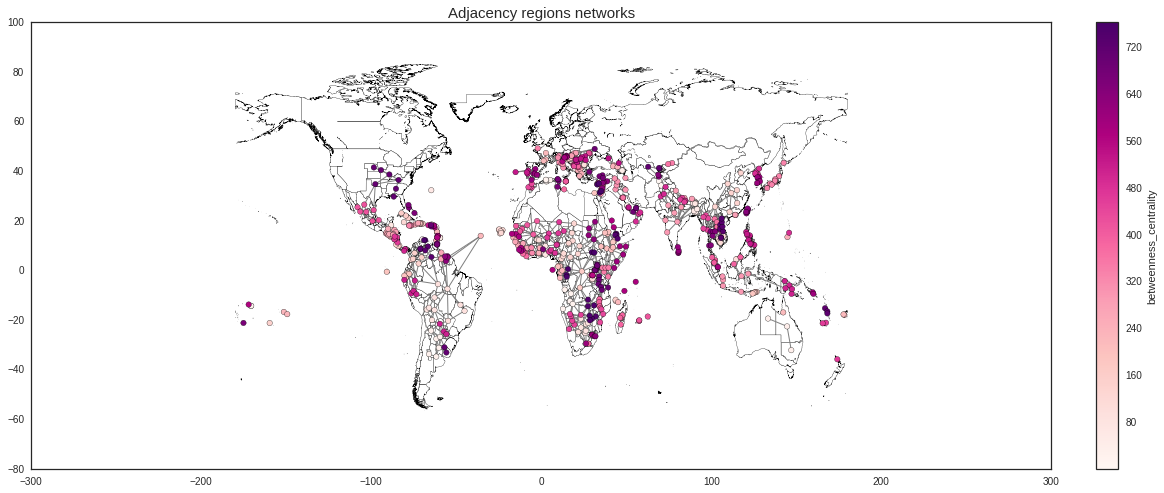

In [20]:
fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    p = PatchCollection(patches,color='white',lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()

nc = nx.draw_networkx_nodes(G_combined,
                            pos=pos,
                            node_size=30,
                            cmap=plt.get_cmap('RdPu'),
                            node_color=[i*1 for i in degree_centrality_dict])
nx.draw_networkx_edges(G_combined,pos=pos,edge_color='gray', alpha=1)
# plt.gca().set_visible(False)
plt.colorbar(nc, orientation='vertical', label="betweenness_centrality", fraction=0.046, pad=0.04);
ax.set_title('Adjacency regions networks', fontsize=15)
ax.set_ylim([-60, 85])
ax.set_xlim([-200, 200])
fig = plt.gcf()
save_fig(fig, './figs/', 'Adjacency regions networks')
plt.show()

In [21]:
degree_centrality_df = pd.DataFrame.from_dict(degree_centrality_dict, orient='index')
gdf_model_elements['adjacmatrix_centrality'] = degree_centrality_df

# Prepare structure to record simulation outcomes in EMA

In [22]:
# This is a very silly way to do this but it works just fine
gdf_model_elements['submodel']=gdf_model_elements.index
df=gdf_model_elements[['submodel']]
in_df = df.copy()
re_df = df.copy()
ex_df = df.copy()
su_df = df.copy()
case_df = df.copy()
in_df['submodel'] =  in_df['submodel'].astype(str) + '_infectious'
ex_df['submodel'] =  ex_df['submodel'].astype(str) + '_exposed'
re_df['submodel'] =  re_df['submodel'].astype(str) + '_recovered_immune'
su_df['submodel'] = su_df['submodel'].astype(str) + '_susceptible'
case_df['submodel'] = case_df['submodel'].astype(str) + '_cumulative_cases'
df = su_df
df = df.append(ex_df)
df = df.append(in_df)
df = df.append(re_df)
df = df.append(case_df)
df.reset_index(drop=True, inplace=True)
df.head(5)


,submodel
0,1_susceptible
1,2_susceptible
2,4_susceptible
3,5_susceptible
4,6_susceptible


#### Save Results

In [23]:
### Save df to record simulation Outcomes 
df.to_csv(r'input_data_simulation/csv_files/Series_model_outcomes.csv', index=False) 

In [24]:
### Save adjacency matrix
adjacency_matrix_df.to_csv(r'input_data_simulation/csv_files/adjacency_matrix.csv') 

In [25]:
gdf_model_elements['lat'] = gdf_model_elements['centroid_largest_landmas'].apply( lambda x: x[0] )
gdf_model_elements['lon'] = gdf_model_elements['centroid_largest_landmas'].apply( lambda x: x[1] )

In [26]:
# Remove intermediate data
lst_columns = ['largest_polygon_geometry', 'submodel', 'mpl_polygon', 'centroid_largest_landmas']
gdf_model_elements = gdf_model_elements.drop(lst_columns, axis=1)

In [27]:
gdf_model_elements['index']=gdf_model_elements.index

In [28]:
gdf_model_elements.head(2)

,Crude_Birth_rate,Messinamea,Poverty_WB,continent,country,country_code,geometry,perc_pover,population,pregnancies,suitability_max,adjacmatrix_centrality,lat,lon,index
1,34.225,0.000030,None,Asia,Afghanistan,AFG,(POLYGON ((69.24567468300006 37.10388621000007...,84.862340,2.163907e+06,55544.781084,0.127761,0.001565,69.249810,36.013437,1
2,34.225,0.000081,None,Asia,Afghanistan,AFG,(POLYGON ((70.06557295800013 33.72101776200012...,84.714404,3.121310e+06,80120.114498,0.173945,0.000000,70.482211,34.245108,2


In [29]:
gdf_model_elements.columns

Index([      u'Crude_Birth_rate',             u'Messinamea',
                   u'Poverty_WB',              u'continent',
                      u'country',           u'country_code',
                     u'geometry',             u'perc_pover',
                   u'population',            u'pregnancies',
              u'suitability_max', u'adjacmatrix_centrality',
                          u'lat',                    u'lon',
                        u'index'],
      dtype='object')

In [30]:
import os
filename = 'preprocessing_results/geojson/gdf_model_elements.geojson'
try:
    os.remove(filename)
except OSError:
    pass
gdf_model_elements.to_file(filename, driver="GeoJSON")